In [1]:
import os

import pandas as pd
import numpy as np
import seaborn as sb

import scipy.stats as st
import sklearn.metrics as skm
import matplotlib.pyplot as plt

# Define costum color palette
colors = ["white", "firebrick", "gold", "darkseagreen", "seagreen"]
species_list = ['$\it{Ae. aegypti}$','$\it{Ae. albopictus}$','$\it{Ae. japonicus}$','$\it{Ae. koreicus}$']
custom_palette = sb.blend_palette(colors, as_cmap=True)

In [2]:
def get_ci(performance_list):
    mean_performance = np.mean(performance_list)
    ci_performance = st.t.interval(0.95,
                                len(performance_list)-1,
                                loc=np.mean(performance_list),
                                scale=st.sem(performance_list))
    
    return round(mean_performance*100,2), (round(ci_performance[0]*100,2) , round(ci_performance[1]*100,2))

def get_ttest(list_accuracy_a, list_accuracy_b):
    statistic, pvalue = st.ttest_ind(list_accuracy_a, list_accuracy_b)
    return statistic, pvalue

In [3]:
df = pd.DataFrame(columns=["depiction", 'seed', 'pred_label', 'highest_score', 'sec_pred_label',
       'sec_highest_score', 'datasplit', 'true_label', 'correct', 'image_path'])

DIR = "results/depiction"
for model in os.listdir(DIR):
    if model.endswith(".pkl"):
        depiction = model.split("_")[1]
        seed = model.split("_")[2]
        
        df_temp = pd.read_pickle(os.path.join(DIR, model))
        
        df_temp["depiction"] = [str(depiction)]*len(df_temp)
        df_temp["seed"] = [int(seed)]*len(df_temp)
        
        df = pd.concat([df, df_temp])    
        
df["image_name"] = [path.split(os.sep)[-1].split(".")[0] for path in df["image_path"]]
df["device"] = [path.split("_")[0] for path in df["image_name"]]
df.drop(columns="image_path", inplace=True)
df = df.reset_index(drop=True)

/var/folders/zq/vkd6f9tx4gdctwbs4b3j895w0000gn/T/ipykernel_56440/3291107009.py:15: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, df_temp])


In [4]:
print(list(df.loc[(df["depiction"] == "wing") & (df["datasplit"] == "test") & (df["seed"] == 9) & (df["true_label"] == "JA") & (df["correct"])].sort_values("highest_score")[-30:-25]["image_name"]))


['Micro_JAb65_l_', 'Micro_JAb83_r_', 'Micro_JAb47_l_', 'Micro_JAa21_l_', 'Macro_JAb48_l_']


/var/folders/zq/vkd6f9tx4gdctwbs4b3j895w0000gn/T/ipykernel_56440/360426582.py:24: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[1][1].set_xticklabels(species_list)
/var/folders/zq/vkd6f9tx4gdctwbs4b3j895w0000gn/T/ipykernel_56440/360426582.py:35: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[1][0].set_xticklabels(["Body", "Wing"])


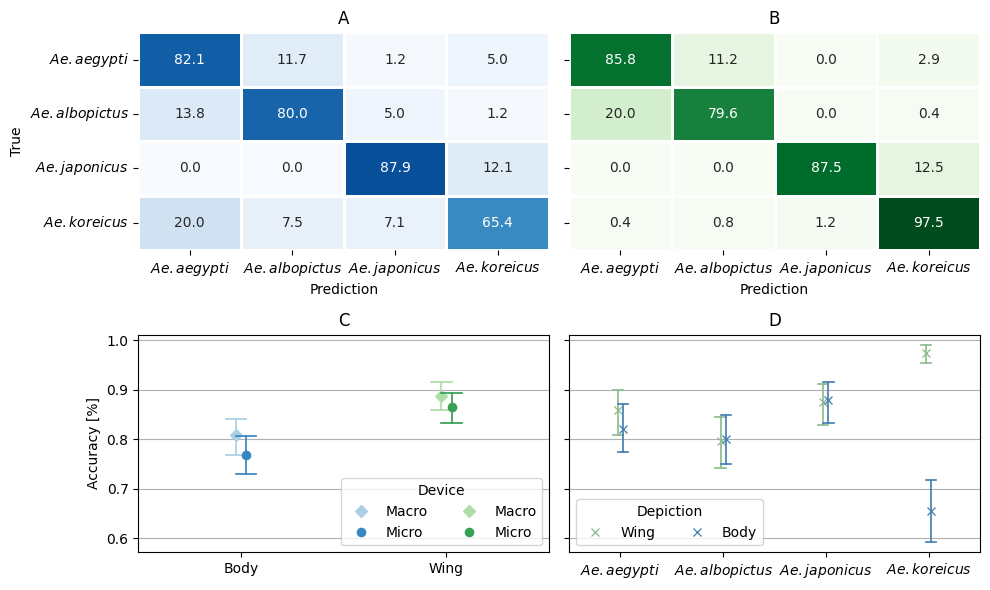

In [5]:
body_crosstab = pd.crosstab(df.loc[(df["depiction"] == "body") & (df["datasplit"] == "test")]["true_label"],
                            df.loc[(df["depiction"] == "body") & (df["datasplit"] == "test")]["pred_label"], normalize="index")*100

wing_crosstab = pd.crosstab(df.loc[(df["depiction"] == "wing") & (df["datasplit"] == "test")]["true_label"],
                            df.loc[(df["depiction"] == "wing") & (df["datasplit"] == "test")]["pred_label"], normalize="index")*100

fig, ax = plt.subplots(2,2,figsize=(10,6), sharey="row")
sb.heatmap(body_crosstab, ax = ax[0][0],
           annot=True, fmt=".1f", linewidth=1, cmap="Blues", vmax=100, linecolor="white" ,cbar=False)
sb.heatmap(wing_crosstab, ax = ax[0][1],
           annot=True, fmt=".1f", linewidth=1, cmap="Greens", vmax=100, linecolor="white", cbar=False)

sb.pointplot(data=df.loc[(df["depiction"] == "body")  & (df["datasplit"] == "test")], hue="device",x = 0, y="correct", errorbar="ci", linestyle="none",
             capsize=.1, linewidth=1.25, markersize=6, marker=["D", "o", "d"], ax= ax[1][0], palette="Blues", dodge=True)
sb.pointplot(data=df.loc[(df["depiction"] == "wing") & (df["datasplit"] == "test") ], hue="device", x = 1, y="correct", errorbar="ci", linestyle="none",
             capsize=.1, linewidth=1.25, markersize=6, marker=["D", "o"], ax= ax[1][0], palette="Greens", dodge=True)

sb.pointplot(df.loc[(df["datasplit"] == "test")], x="true_label", y="correct", hue="depiction", ax=ax[1][1], dodge=True,
             errorbar="ci", linestyle="none", capsize=.1, linewidth=1.25, markersize=6, marker="x", palette=["darkseagreen", "steelblue"])

ax[0][0].set_yticklabels(species_list, rotation=0)
ax[0][0].set_xticklabels(species_list)
ax[0][1].set_xticklabels(species_list)
ax[1][1].set_xticklabels(species_list)

ax[0][0].set_ylabel("True")
ax[0][1].set_ylabel("")
ax[1][0].set_ylabel("Accuracy [%]")

ax[0][0].set_xlabel("Prediction")
ax[0][1].set_xlabel("Prediction")
ax[1][1].set_xlabel("")

ax[1][0].set_yticks(np.arange(0.6,1.01,.1))
ax[1][0].set_xticklabels(["Body", "Wing"])

ax[1][0].grid(axis="y")
ax[1][1].grid(axis="y")


ax[1][0].legend(title='Device', fancybox=True, ncol=2, loc="lower right")
legend = ax[1][1].legend(title='Depiction', fancybox=True, ncol=2, loc="lower left")
# Create legend with custom properties and store the legend object

# Capitalize labels
for text in legend.get_texts():
    text.set_text(text.get_text().capitalize())

ax[0][0].set_title("A")
ax[1][0].set_title("C")
ax[0][1].set_title("B")
ax[1][1].set_title("D")

plt.tight_layout()
plt.savefig("figures/depiction_comparison.svg", dpi=500)

In [6]:
list(df.loc[(df["depiction"] == "wing") & (df["datasplit"] == "test")].groupby("seed")["correct"].mean())

[0.8916666666666667, 0.85, 0.8958333333333334, 0.8666666666666667]

In [7]:
get_ci(list(df.loc[(df["depiction"] == "body") & (df["datasplit"] == "test")].groupby("seed")["correct"].mean()))

(78.85, (77.72, 79.99))

In [8]:
get_ci(list(df.loc[(df["depiction"] == "wing") & (df["datasplit"] == "test")].groupby("seed")["correct"].mean()))

(87.6, (84.16, 91.04))

In [9]:
get_ttest(list(df.loc[(df["depiction"] == "wing") & (df["datasplit"] == "test")].groupby("seed")["correct"].mean()),
          list(df.loc[(df["depiction"] == "body") & (df["datasplit"] == "test")].groupby("seed")["correct"].mean()))

(7.689505290986649, 0.0002532776546156391)

In [10]:
wing = df.loc[(df["depiction"] == "wing") & (df["datasplit"] == "test")].groupby(["true_label"])["correct"].mean()

In [11]:
body = df.loc[(df["depiction"] == "body") & (df["datasplit"] == "test")].groupby(["true_label"])["correct"].mean()

In [12]:
(wing - body)*100

true_label
AE         3.75
AL    -0.416667
JA    -0.416667
KO    32.083333
Name: correct, dtype: object